# Tranvelling Salesman Problem with Quri-parts
## Write TSP mathematical model with jijmodeling
Usually, we need several steps to solve a mathematical optimization problem with a quantum algorithm such as QAOA or VQE.
The steps are

1. describe the mathematical model
2. transform the mathematical model into QUBO form
3. transform the QUBO form into the Ising form
In this section, we will look at these steps specifically using the TSP.

First, let us describe the mathematical model of the TSP.
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n}\\
\mathrm{s.t.}~&\sum_i x_{i, t} = 1,~\forall t\\
&\sum_t x_{i, t} = 1, ~\forall i\\
&x_{i, t} \in \{0, 1\}
\end{aligned}
$$
where $d_{i,j}$ is distance between city $i$ and city $j$.
A detailed description of the mathematical model is omitted, but the important point here is that merely describing the mathematical model is not a form that can be handled by quantum algorithms.

Next, the mathematical model needs to be converted to Quadratic Unconstraint Binary Optimisation (QUBO) format.
A typical conversion method is the Penalty method. This is a method for transforming a mathematical model into the following form.
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

Finally, this QUBO form needs to be converted to Ising form.
In other words, it is necessary to convert the QUBO into the Ising model by converting the binary variables into spin variables as $x_i = \frac{1}{2}(1 - z_i)$.
Here, the specific calculations are too cumbersome to write down, but formally, the conversion is as follows
$$
\begin{aligned}
\sum_{i,j} Q_{i,j}x_i,x_j \to \sum_{i,j}J_{i,j}z_iz_j + \sum_ih_i z_i 
\end{aligned}
$$
Now, as can be seen from the above, it is quite tedious just to convert a mathematical model. The most of the researcher would like to build their own algorithm, but building the Hamiltonian.

Therefore, `jijmodeling-transpiler-quantum` is a tool that automatically performs the tediousness of the above conversion.

Let's see how to use it concretely below.

In [1]:
from __future__ import annotations
import jijmodeling as jm
import jijmodeling_transpiler as jmt
import jijmodeling_transpiler_quantum.quri_parts as jq_qu

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import numpy as np
import matplotlib.pyplot as plt

First, the mathematical model is described using JijModeling.

Here, the variables used in the mathematical model are defined, and the objective function and constraints are described using these variables.

In [23]:
def tsp():

    # define variables
    d = jm.Placeholder("d", ndim=2)
    N = d.len_at(0, latex="N")
    i = jm.Element("i", belong_to=(0, N))  # city index
    j = jm.Element("j", belong_to=(0, N))  # city index
    t = jm.Element("t", belong_to=(0, N))  # time index or step index
    x = jm.BinaryVar("x", shape=(N, N))

    # set problem
    problem = jm.Problem("TSP")
    problem += jm.sum([i, j], d[i, j] * jm.sum(t, x[i, t] * x[j, (t + 1) % N]))
    problem += jm.Constraint("one-city", jm.sum(i, x[i, t]) == 1, forall=t)
    problem += jm.Constraint("one-time", jm.sum(t, x[i, t]) == 1, forall=i)
    problem
    return problem


def plot_instance(x_pos: np.ndarray, y_pos: np.ndarray):
    plt.plot(x_pos, y_pos, "o", color="blue")
    plt.show()

In [24]:
problem = tsp()
problem

JijModeling allows you to check the mathematical model in Tex format, as described above, and to check whether the mathematical model you have programmed matches the mathematical model you have written at hand.

In [25]:
def generate_random_instance(n):
    x_pos = np.random.rand(n)
    y_pos = np.random.rand(n)
    XX, XX_T = np.meshgrid(x_pos, x_pos)
    YY, YY_T = np.meshgrid(y_pos, y_pos)
    distance = np.sqrt((XX - XX_T) ** 2 + (YY - YY_T) ** 2)
    return x_pos, y_pos, distance

In [86]:
x_pos, y_pos, distance = generate_random_instance(4)

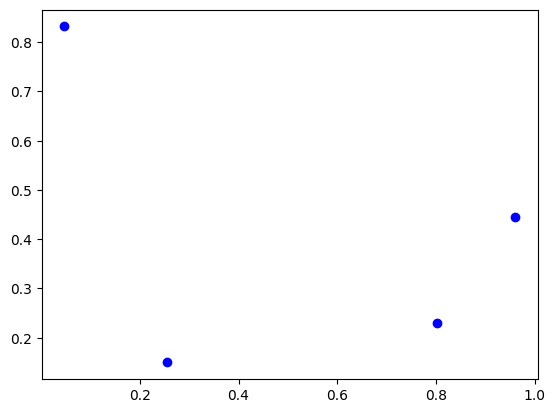

In [87]:
plot_instance(x_pos, y_pos)

## Generate Quri-parts Hamiltonian with jijmodeling-transpiler-quantum

In [88]:
compiled_instance = jmt.core.compile_model(tsp(), {"d": distance})

Next, set up information such as how QUBOs are to be converted in order to create QAOA Ansatz.
For example, how the mathematical model is to be converted to QUBO can also be set. The Penalty method or the Augment Lagrangian method as described above can also be used for conversion.

Augumented Lagrangian Method : Adding Linear and Quadratic term to Objective function
$$
\begin{aligned}
\min_x \sum_{i, j} &d_{i,j} \sum_t x_{i,t} x_{j, (t+1) \mod n} + \sum_t \xi_t \left(\sum_i x_{i, t} - 1\right) + \sum_t \mu_t \left(\sum_i x_{i, t} - 1\right)^2 + \sum_i \zeta_i \left(\sum_t x_{i, t} - 1 \right) +  \sum_i \lambda_i \left(\sum_t x_{i, t} - 1 \right)^2\\
\end{aligned}
$$

In [89]:
qaoa_builder = jq_qu.transpile_to_qaoa_ansatz(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.SquaredPenalty)

# You can also use Augumented Lagrangian method to build QUBO
# qaoa_builder = transpile_to_qaoa_ansatz(compiled_instance, relax_method = jmt.core.pubo.RelaxationMethod.AugmentedLagrangian)

In [57]:
ising_operator, constant= qaoa_builder.get_hamiltonian(multipliers = {'one-city':1,'one-time':1})

Finally, `get_qaoa_ansatz` can be used to obtain the parametrized circuit, objective function, etc. of the QAOA.
At this time, the number of layers of QAOA and the coefficients of the above Penalty method can also be set in detail. (Default value is 1).

In [93]:
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(p=1,multipliers = {'one-city':1,'one-time':1})

Now that the qiskit QAOA circuit has been obtained, programming can be carried out using quri-parts from this point onwards.

In [94]:
print("Qubit count:", qaoa_ansatz.qubit_count)
print("Circuit depth:", qaoa_ansatz.depth)

# A parametric circuit object does not have .gates property.

print("Parameter count:", qaoa_ansatz.parameter_count)


Qubit count: 16
Circuit depth: 23
Parameter count: 2


Now that the qiskit QAOA circuit has been obtained, programming can be carried out using qiskit from this point onwards.

# Run QAOA

In [95]:
def run_qaoa_with_log(
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    hamiltonian: Operator,
    method: str | callable,
) -> tuple[OptimizeResult, list[float]]:
    def _cost_func(parameters, ansatz, hamiltonian, estimator):
        parametric_state = ParametricCircuitQuantumState(
            ansatz.qubit_count, ansatz
        )
        estimate = estimator(hamiltonian, parametric_state, parameters)
        return estimate.value.real

    initial_params = np.array([1.0] * ansatz.parameter_count)

    estimator = create_qulacs_vector_parametric_estimator()
    optimization_history: list[float] = []

    result = minimize(
        _cost_func,
        initial_params,
        args=(ansatz, hamiltonian, estimator),
        method=method,
        callback=lambda x: optimization_history.append(
            _cost_func(x, ansatz, hamiltonian, estimator)
        ),
    )

    return result, optimization_history

In [96]:
result,optimization_history = run_qaoa_with_log(qaoa_ansatz, hamiltonian, "COBYLA")

Text(0, 0.5, 'cost function')

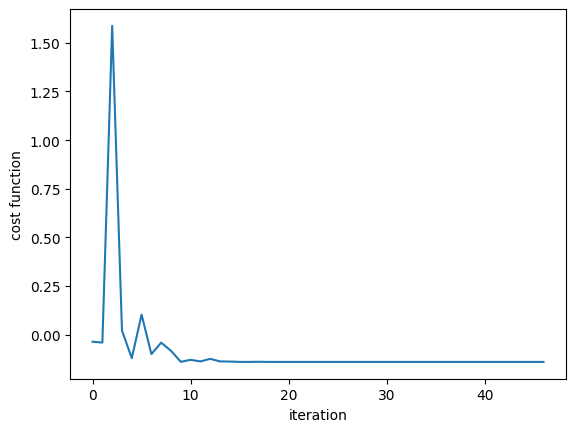

In [97]:
plt.plot(optimization_history)
plt.xlabel('iteration')
plt.ylabel('cost function')

# Decode the result
For sampling results on Hamiltonians obtained using `jijmodeling-transpiler-quantum`, the decode function can be used to convert them into a more readable and analyseable form.

In [98]:
def sample_result(
    result: OptimizeResult,
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    num_qubits: int,
    num_shots: int = 10000,
) -> jm.SampleSet:
    bind_ansatz_opt = ansatz.bind_parameters(result.x)
    sampler = create_qulacs_vector_sampler()
    sampling_result = sampler(bind_ansatz_opt, num_shots)
    result_bits = {
        bin(key)[2:].zfill(num_qubits)[::-1]: val
        for key, val in sampling_result.items()
    }
    sampleset = qaoa_builder.decode_from_counts(result_bits)
    return sampleset

In [99]:
sampleset = sample_result(result, qaoa_ansatz, qaoa_ansatz.qubit_count)

In [100]:
def sampleset_to_tour(sampleset: jm.SampleSet) -> list[list[int]]:
    data = sampleset.lowest().record.solution

    if data:
        tours = []
        for indices, val, shape in data["x"]:
            tour, _ = zip(*sorted(zip(*indices), key=lambda x: x[1]))
            tours.append(list(tour))
        return tours
    else:
        return []

In [102]:
tours = sampleset_to_tour(sampleset)
tours

[[3, 0, 1, 2], [0, 1, 2, 3]]

In [103]:
def plot_tour(tour: list[int], x_pos: np.ndarray, y_pos: np.ndarray):
    _tour = tour + [tour[0]]
    _tour = np.array(_tour)
    plt.plot(
            x_pos[_tour],
            y_pos[_tour],
            "o-",
            color="blue",
        )
        
    plt.plot(x_pos, y_pos, "o", color="blue")
    plt.show()

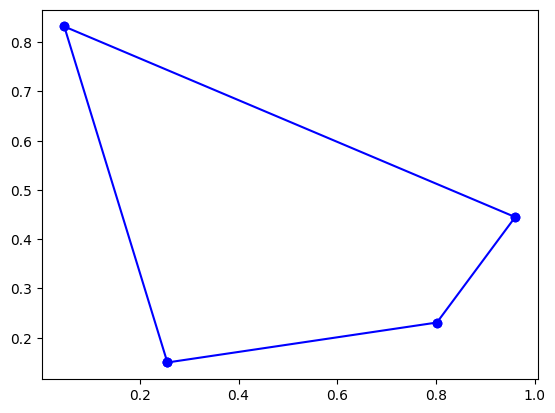

In [104]:
plot_tour(tours[0], x_pos, y_pos)